### Reflection

Reflection is a technique where we ask LLM to generate and critique the generated content (could run it in a loop or while the critique is satisfied), let's implement this architecture.

In [1]:
from typing import Annotated, TypedDict

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages

In [2]:
model = ChatOpenAI()

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [8]:
generate_prompt = SystemMessage(
    """You are an essay assistant tasked with writing excellent 3-paragraph
    essays."""
    "Generate the best essay possible for the user's request."
    """If the user provides critique, respond with a revised version of your
    previous attempts."""
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state["messages"])
    return {"messages" : [answer]}

In [13]:
reflection_prompt = SystemMessage(
    """You are a teacher grading an essay submission. Generate critique and
    recommendations for the user's submission."""
    """Provide detailed recommendations, including requests for length, depth,
    style, etc."""
)

def reflect(state: State) -> State:
    # invert the messages to feed LLM it's own output
    class_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
    # the first message passed to the model is original request, we pass it to all nodes, also change AIMessage to HumanMessage and vice-versa
    translated = [reflection_prompt , state["messages"][0]] + [class_map[msg.__class__](msg.content) for msg in state["messages"][1:]]
    answer = model.invoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=answer.content)]}

In [14]:
def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations, each with 2 messages
        return END
    else:
        return "reflect"

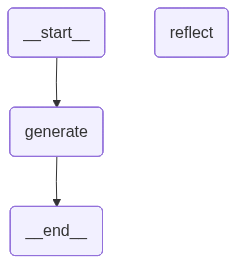

In [15]:
builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)
builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

graph

In [16]:
input = {
 "messages": [
 HumanMessage("""Write an essay on the topicality of "The Lord of the Rings" and its message.""")]
}

for c in graph.stream(input):
    print(c)

{'generate': {'messages': [AIMessage(content='"The Lord of the Rings" by J.R.R. Tolkien continues to be a timeless classic that resonates with audiences worldwide due to its enduring themes and messages. One of the key reasons for the topicality of this epic fantasy is its exploration of the eternal struggle between good and evil. Through the adventures of characters like Frodo, Sam, and Aragorn, Tolkien delves into the complexities of morality, power, and the choices individuals make in the face of adversity. This message remains relevant today as society continues to grapple with similar moral dilemmas and ethical challenges.\n\nMoreover, "The Lord of the Rings" offers a profound commentary on the nature of courage, friendship, and sacrifice. The journey of the Fellowship exemplifies the power of unity and the strength that can be derived from working together towards a common goal. In a world where individualism often prevails, Tolkien\'s depiction of camaraderie and selflessness se